In [1]:
import os
import sys

import numpy as np

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset

In [5]:
data = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12'
ifp_dir = 'ifp/ifp1'
mcss_dir = 'mcss/mcss1'

In [6]:
gpcrs = ['B1AR','B2AR','A2AR']
kinases = ['BRAF','CDK2','CHK1','JAK2','PLK1']
nuclear = ['AR','ERA','GCR','VITD']

In [10]:
all_data = Dataset(data, kinases)

all_data.load_docking(glide_dir, ifp_dir, mcss_dir, structs={},
                      load_fp=False, load_crystal=False,
                      load_chembl=False, load_mcss=False)

/scratch/PI/rondror/jbelk/method/data/CDK2/docking/glide12 3R7Y_lig 1CKP
/scratch/PI/rondror/jbelk/method/data/CDK2/docking/glide12/3R7Y_lig-to-1CKP /scratch/PI/rondror/jbelk/method/data/CDK2/ifp/ifp1/3R7Y_lig-to-1CKP.fp
/scratch/PI/rondror/jbelk/method/data/CDK2/docking/glide12 3R7Y_lig 1E1V
/scratch/PI/rondror/jbelk/method/data/CDK2/docking/glide12/3R7Y_lig-to-1E1V /scratch/PI/rondror/jbelk/method/data/CDK2/ifp/ifp1/3R7Y_lig-to-1E1V.fp
/scratch/PI/rondror/jbelk/method/data/CDK2/docking/glide12 3R7Y_lig 1E9H
/scratch/PI/rondror/jbelk/method/data/CDK2/docking/glide12/3R7Y_lig-to-1E9H /scratch/PI/rondror/jbelk/method/data/CDK2/ifp/ifp1/3R7Y_lig-to-1E9H.fp
/scratch/PI/rondror/jbelk/method/data/CDK2/docking/glide12 3R7Y_lig 1FIN
/scratch/PI/rondror/jbelk/method/data/CDK2/docking/glide12/3R7Y_lig-to-1FIN /scratch/PI/rondror/jbelk/method/data/CDK2/ifp/ifp1/3R7Y_lig-to-1FIN.fp


BRAF 1UWH
2 did not dock


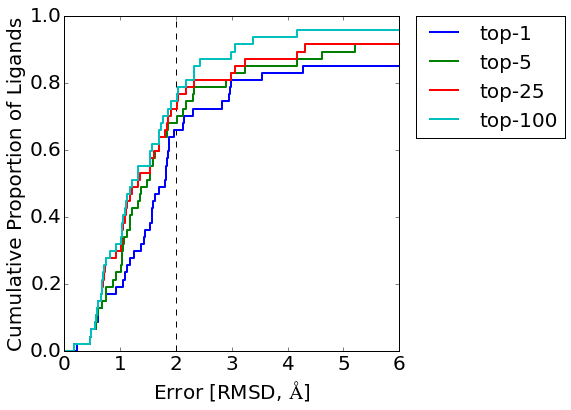

47
1UWH 0.744680851064
BRAF 2FB8
2 did not dock


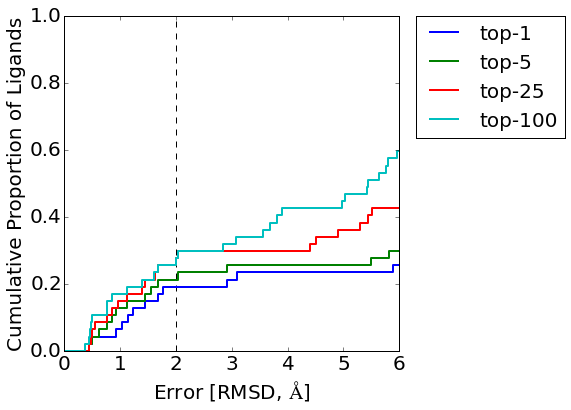

47
BRAF 3C4C
2 did not dock


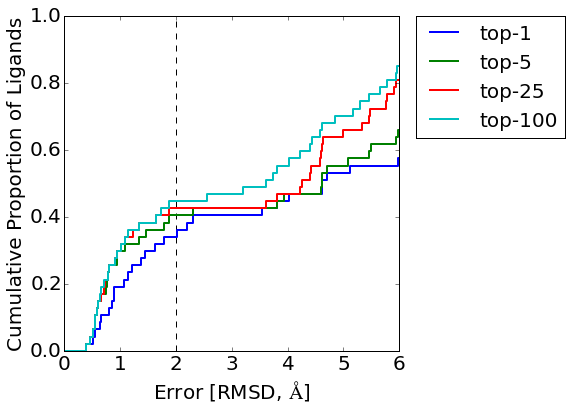

47
BRAF 3D4Q
2 did not dock


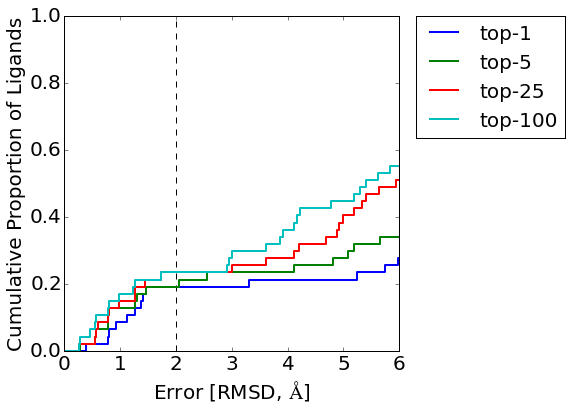

47
BRAF 3IDP
2 did not dock


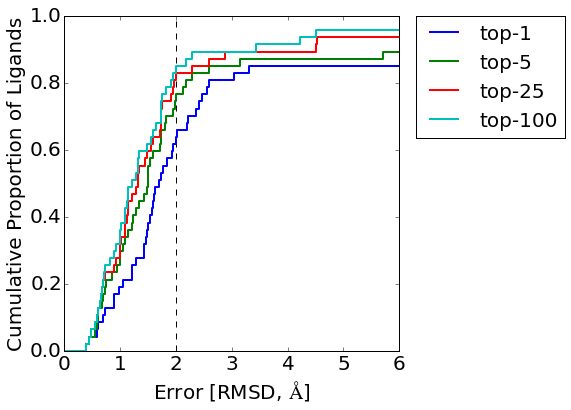

47
3IDP 0.829787234043
BRAF 3II5
2 did not dock


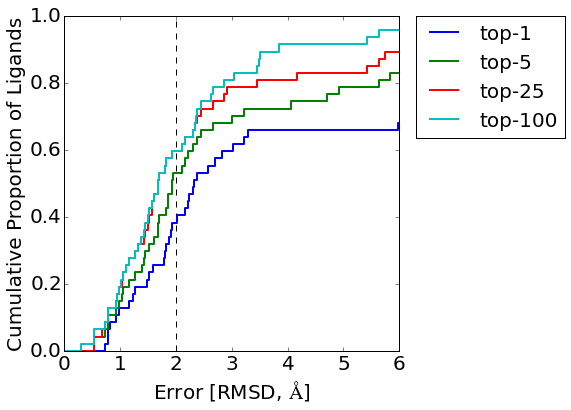

47
BRAF 3PPJ
2 did not dock


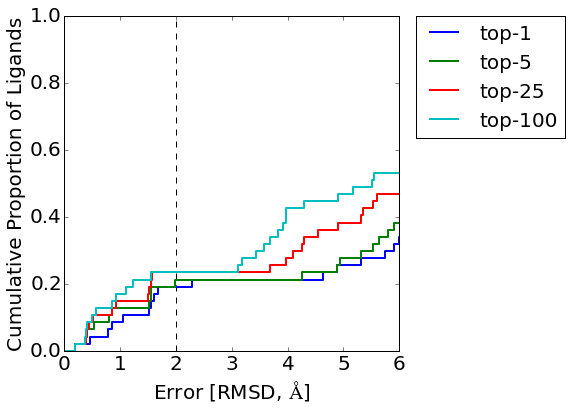

47
BRAF 3PPK
2 did not dock


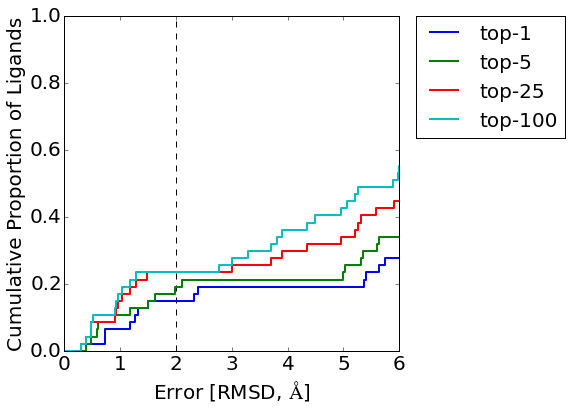

47
BRAF 3PRF
2 did not dock


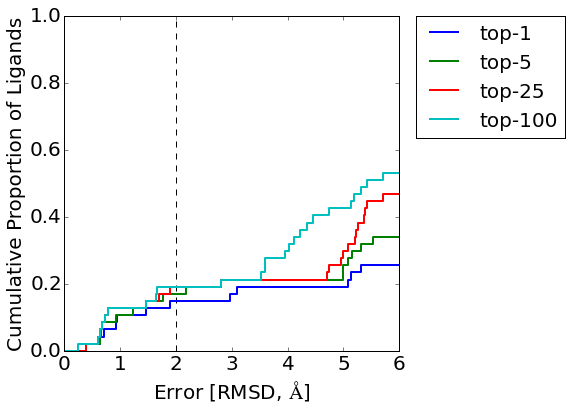

47
BRAF 3PRI
2 did not dock


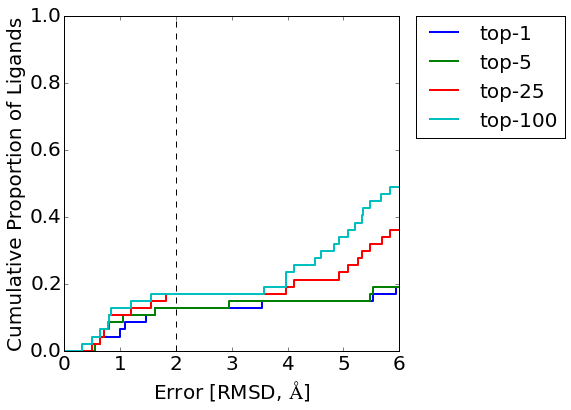

47
BRAF 3PSB
2 did not dock


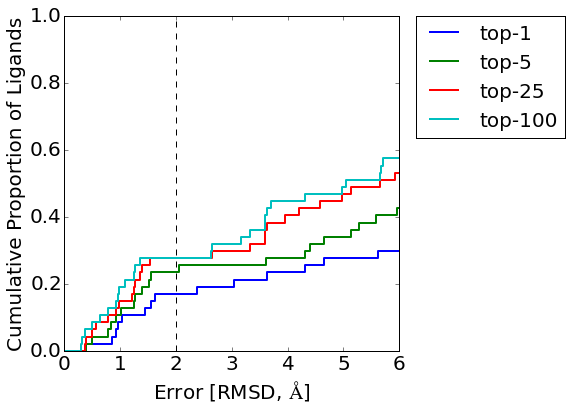

47
BRAF 3PSD
2 did not dock


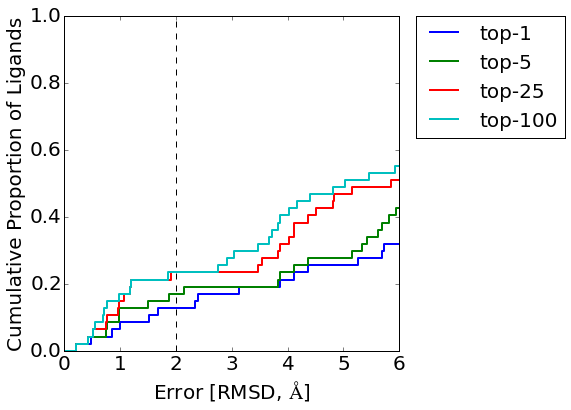

47
CDK2 1AQ1
3 did not dock


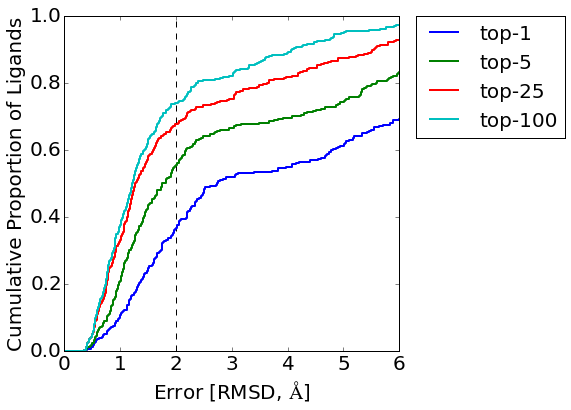

292
1AQ1 0.739726027397
CDK2 1CKP
3 did not dock


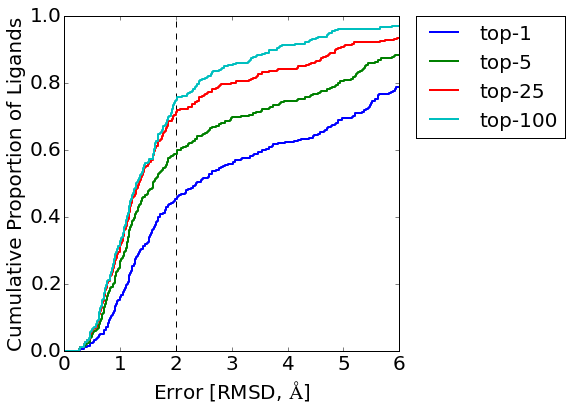

292
1CKP 0.75
CDK2 1DI8
3 did not dock


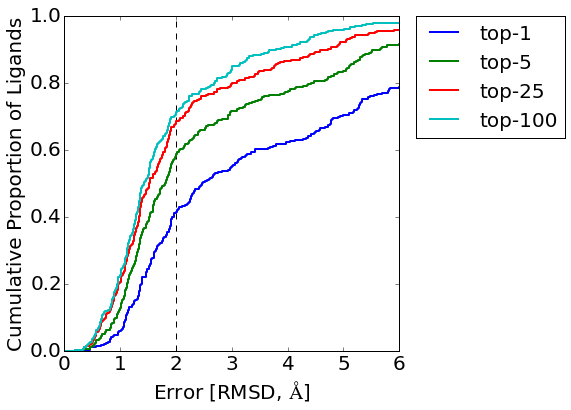

292
CDK2 1DM2
3 did not dock


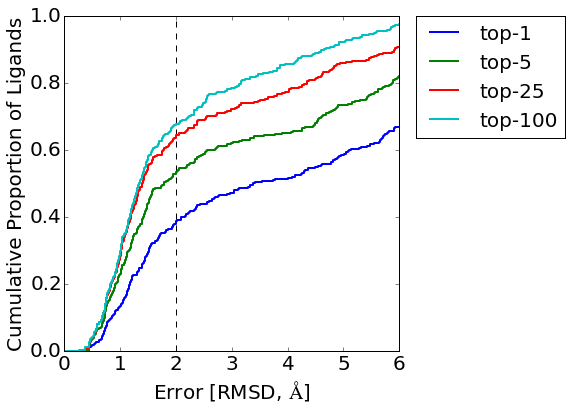

292
CDK2 1E1V
3 did not dock


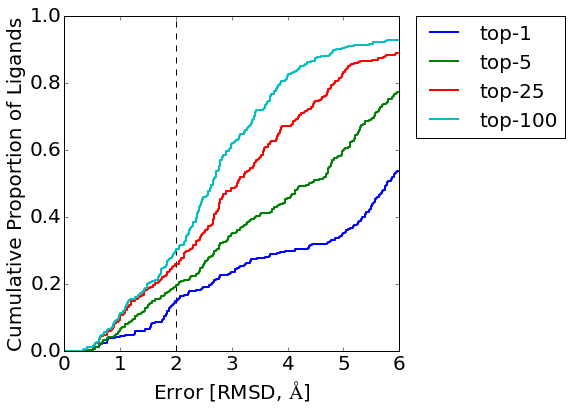

292
CDK2 1E1X
3 did not dock


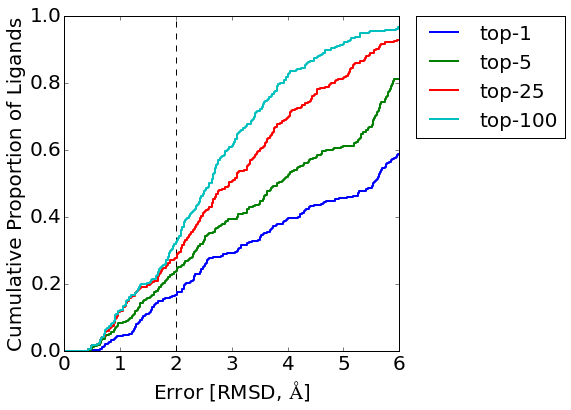

292
CDK2 1E9H
3 did not dock


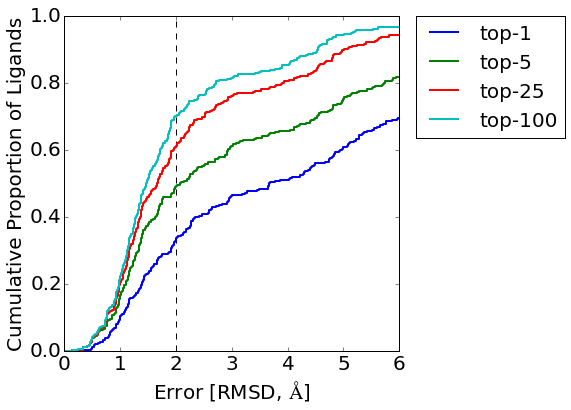

292
CDK2 1FIN
3 did not dock


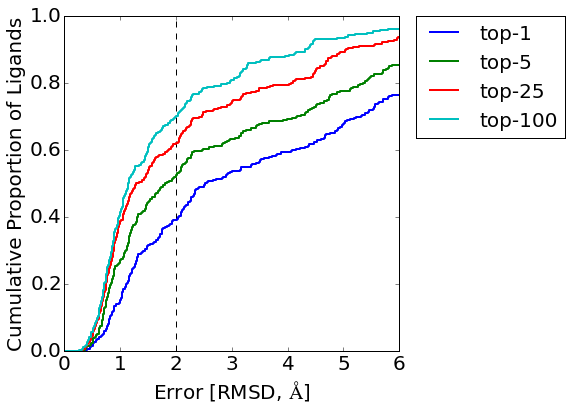

292
CDK2 1FVT
3 did not dock


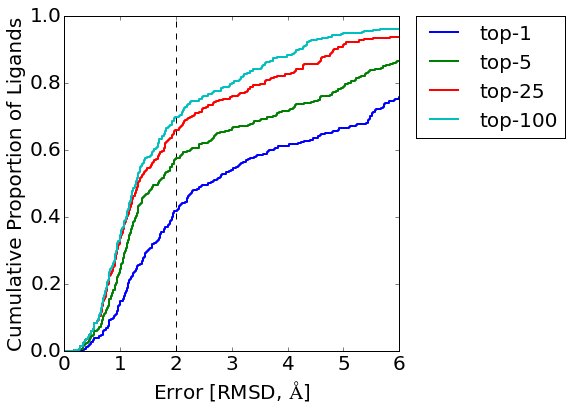

292
CDK2 1FVV
3 did not dock


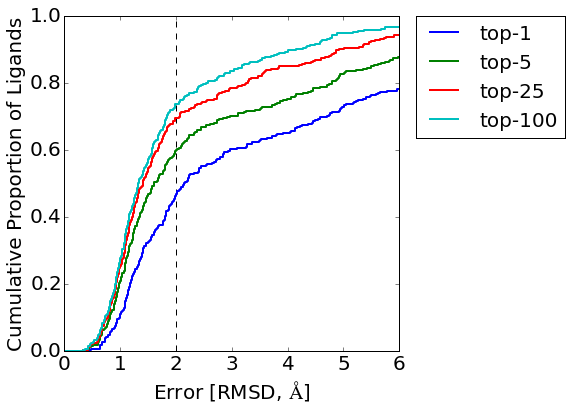

292
CDK2 1G5S
3 did not dock


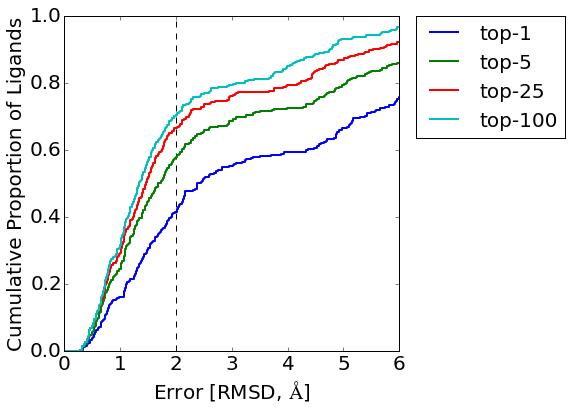

292
CDK2 1GIH
3 did not dock


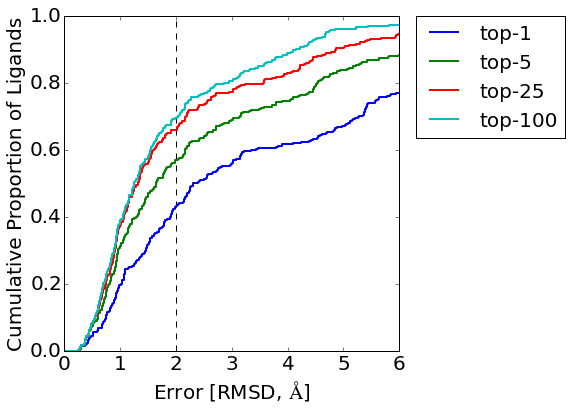

292
CDK2 1H1S
4 did not dock


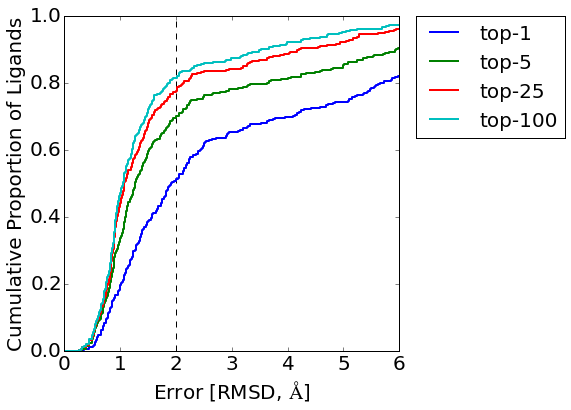

292
1H1S 0.815068493151
CHK1 1NVQ
3 did not dock


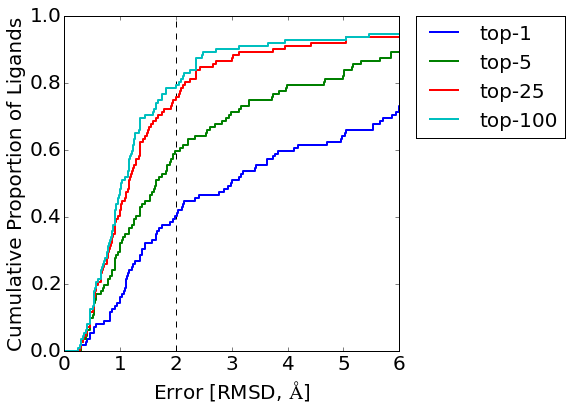

112
1NVQ 0.794642857143
CHK1 1NVR
3 did not dock


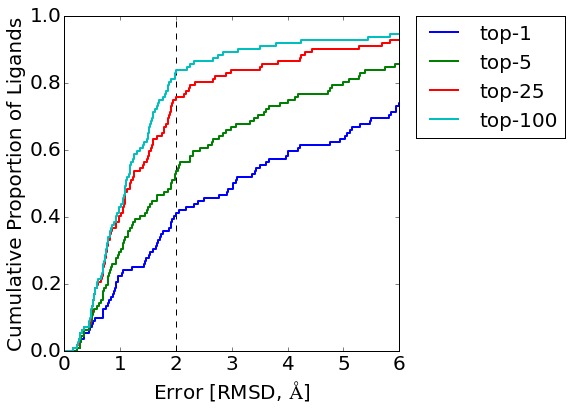

112
1NVR 0.830357142857
CHK1 1NVS
3 did not dock


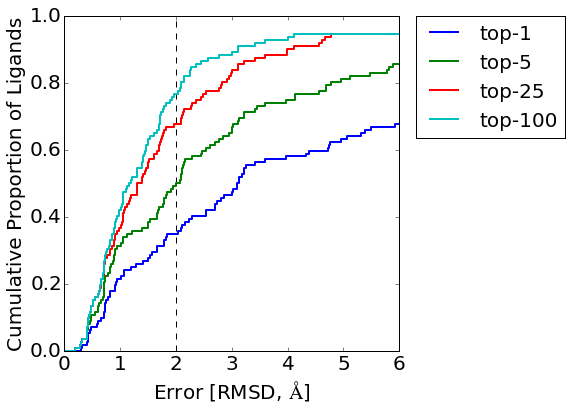

112
CHK1 1ZLT
3 did not dock


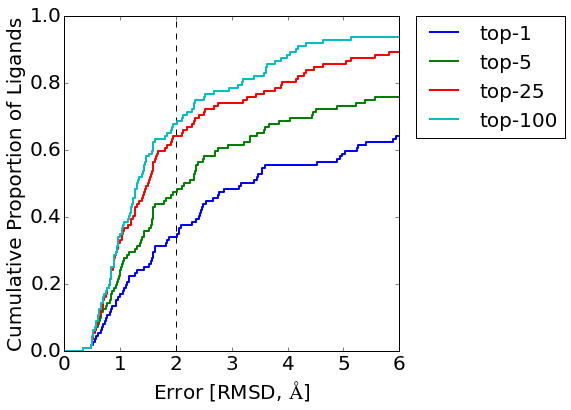

112
CHK1 1ZYS
3 did not dock


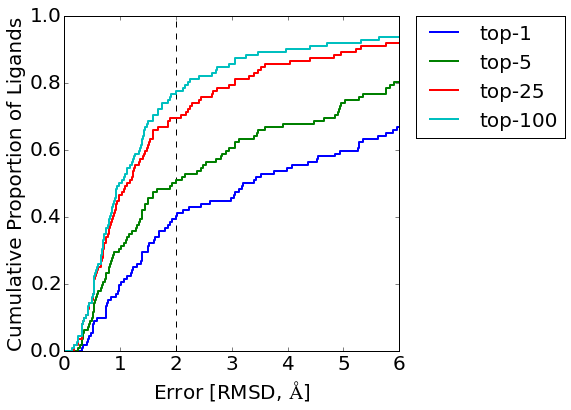

112
CHK1 2AYP
3 did not dock


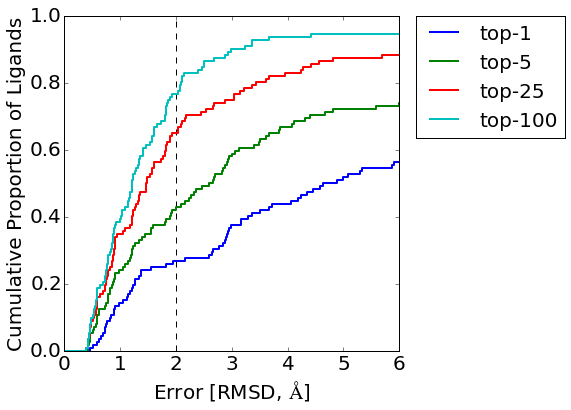

112
CHK1 2BR1
3 did not dock


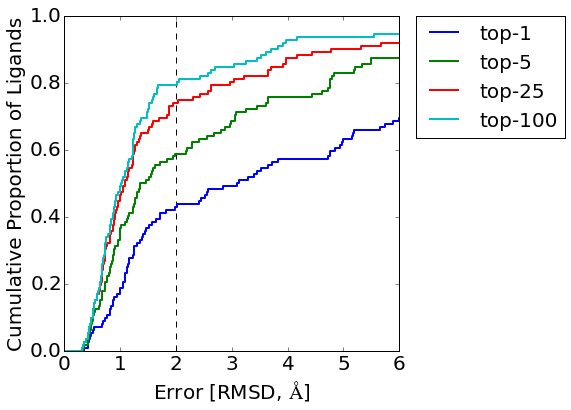

112
CHK1 2BRB
3 did not dock


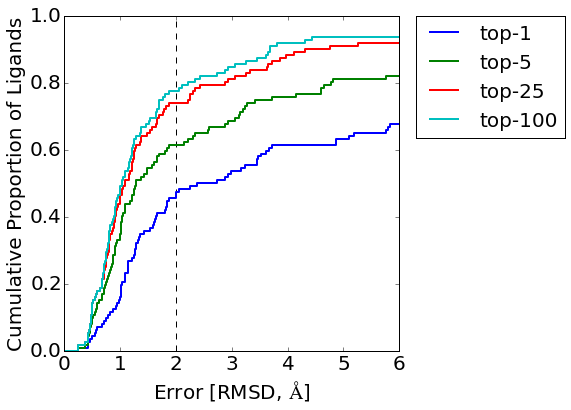

112
CHK1 2BRG
3 did not dock


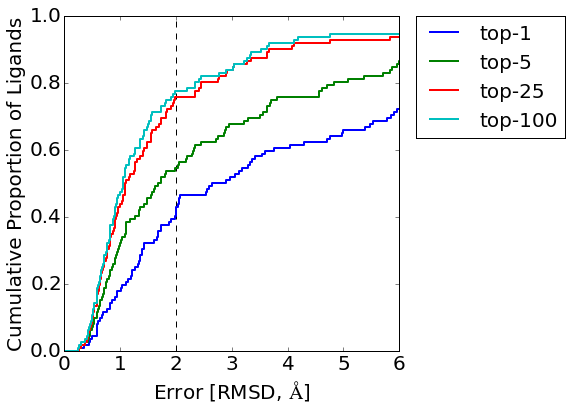

112
CHK1 2BRH
3 did not dock


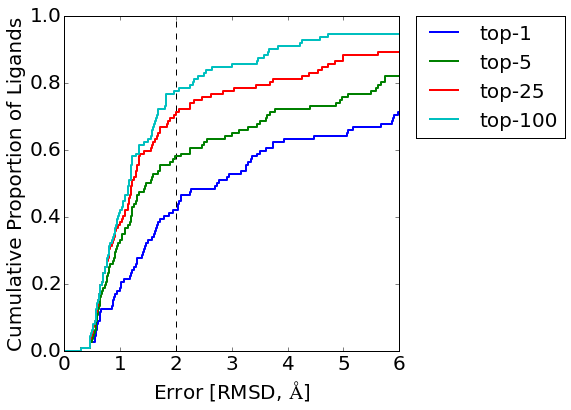

112
CHK1 2BRM
3 did not dock


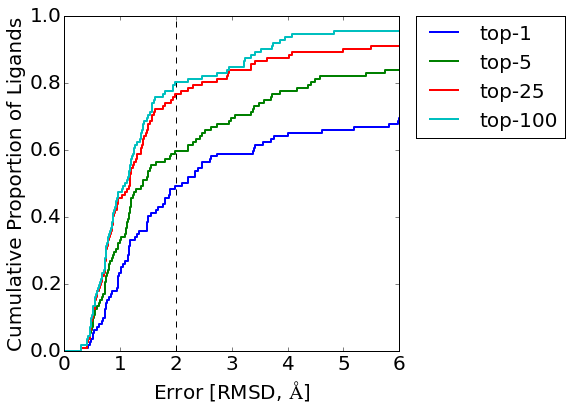

112
CHK1 2BRN
3 did not dock


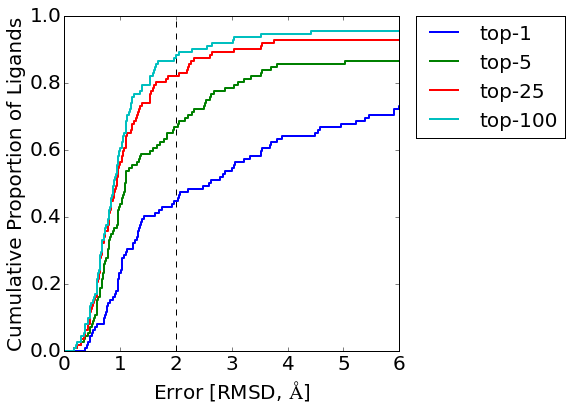

112
2BRN 0.883928571429
JAK2 2B7A


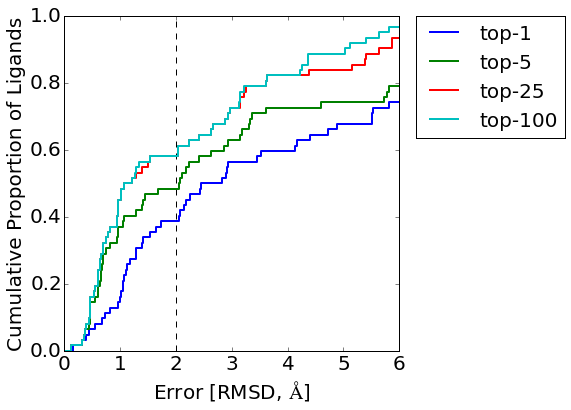

62
2B7A 0.58064516129
JAK2 2W1I


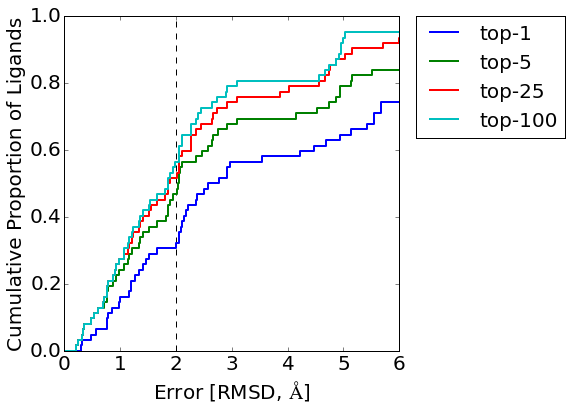

62
JAK2 2XA4


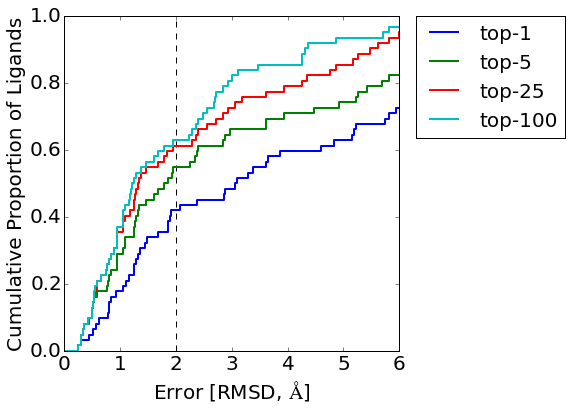

62
2XA4 0.629032258065
JAK2 3E62


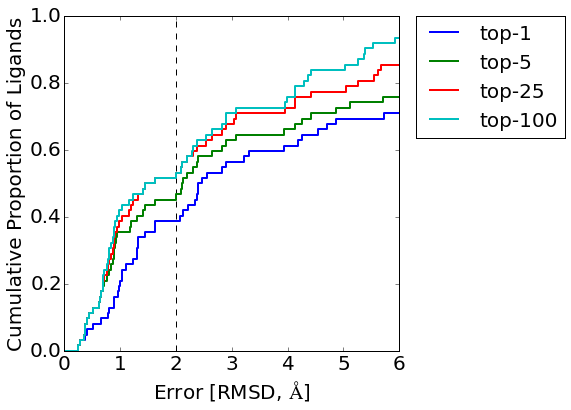

62
JAK2 3E63


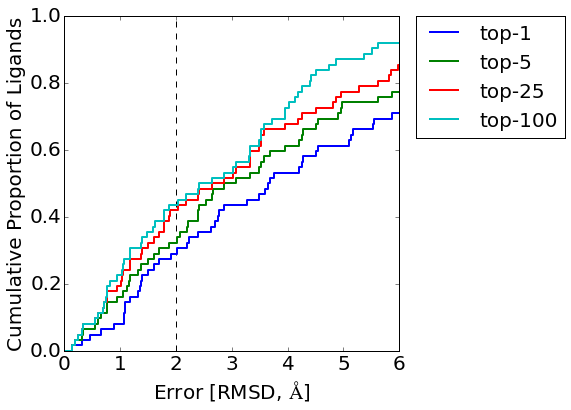

62
JAK2 3E64


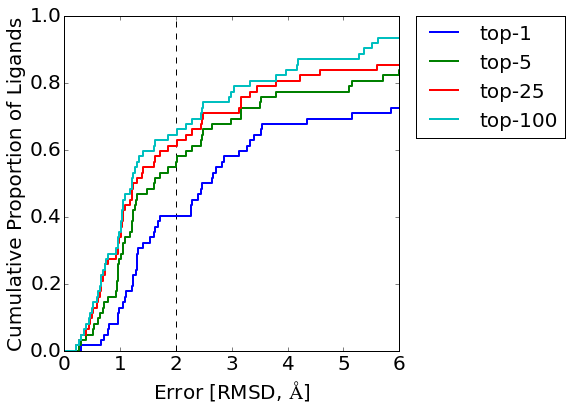

62
3E64 0.645161290323
JAK2 3FUP


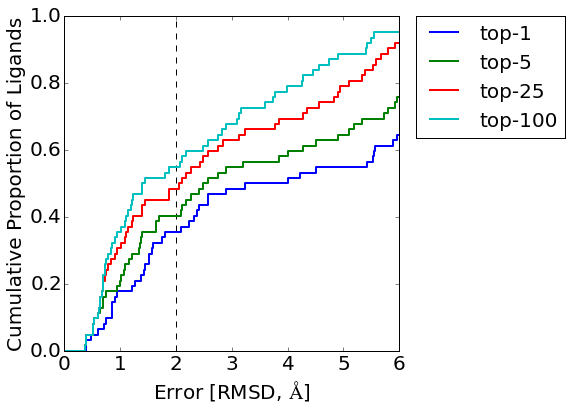

62
JAK2 3IO7


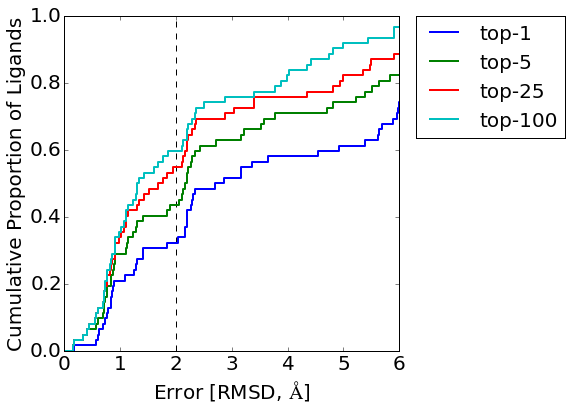

62
JAK2 3IOK


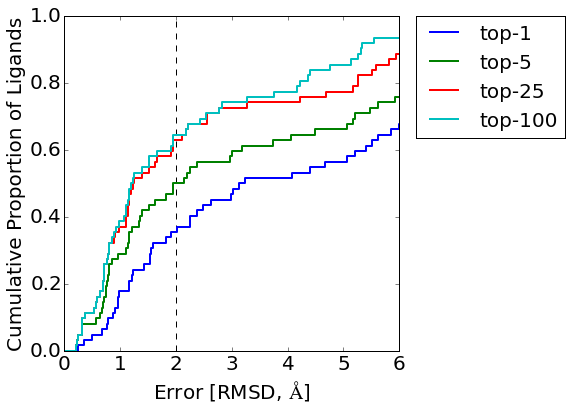

62
JAK2 3JY9


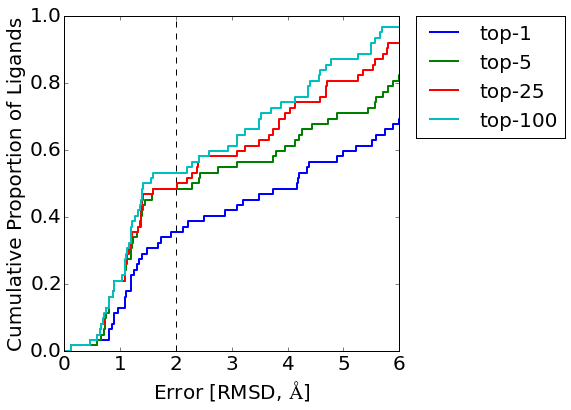

62
JAK2 3KCK


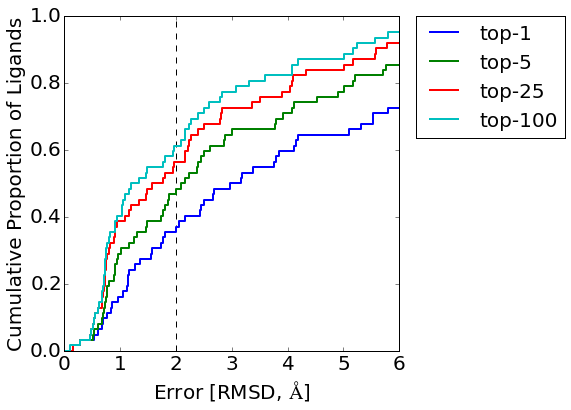

62
JAK2 3KRR


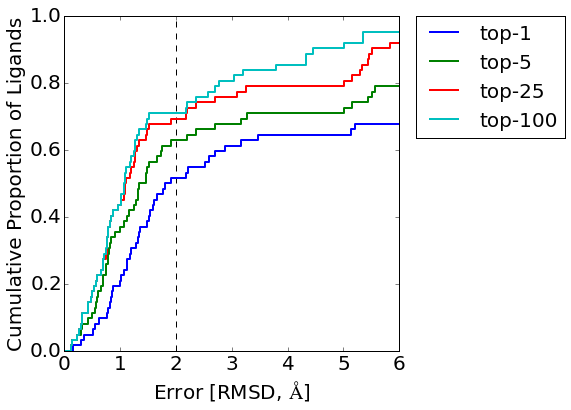

62
3KRR 0.709677419355
PLK1 2OWB


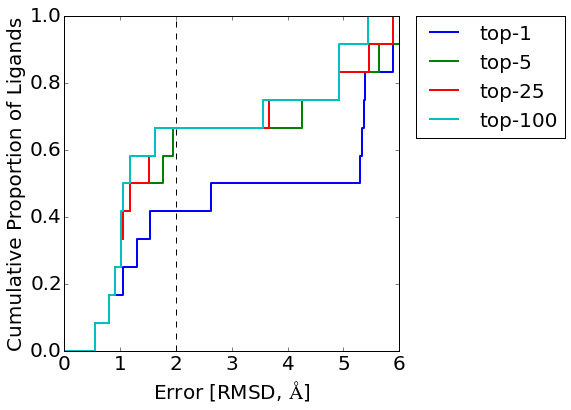

12
2OWB 0.666666666667
PLK1 2RKU


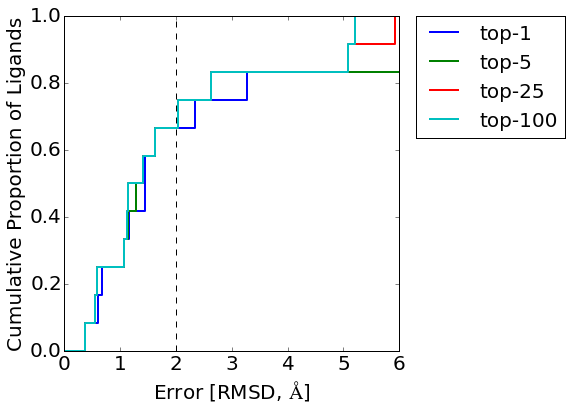

12
PLK1 2YAC


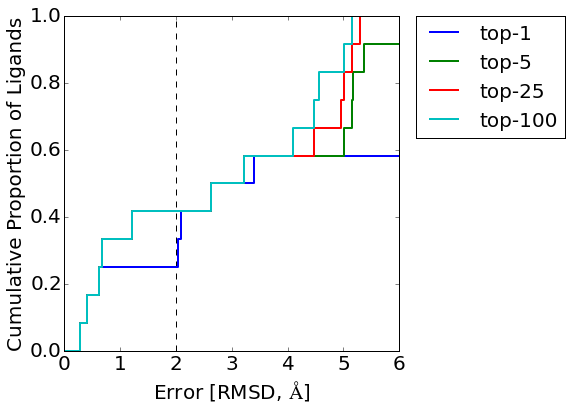

12
PLK1 3FC2


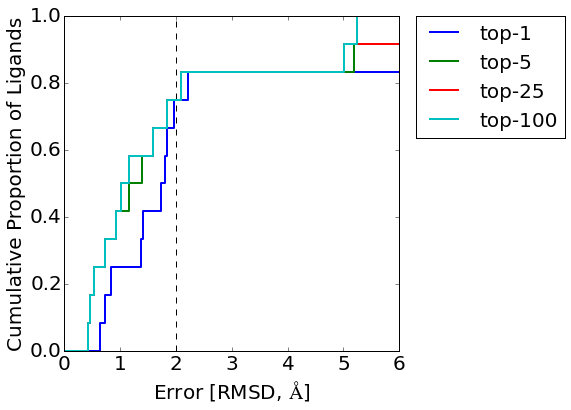

12
3FC2 0.75
PLK1 3KB7


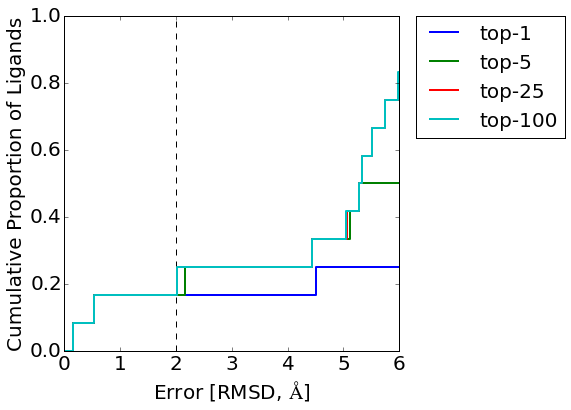

12
PLK1 3THB


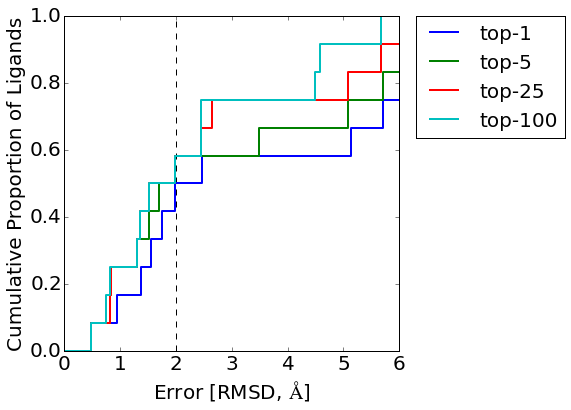

12
PLK1 4A4L


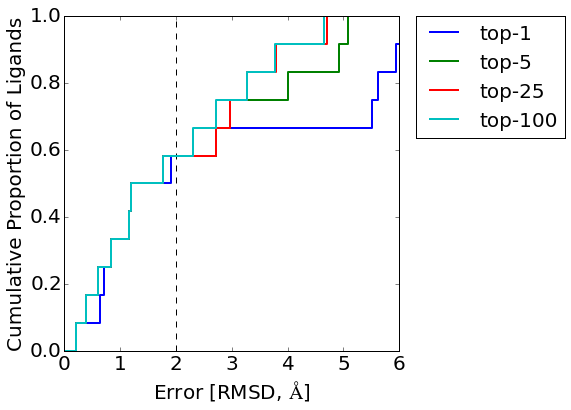

12
PLK1 4A4O


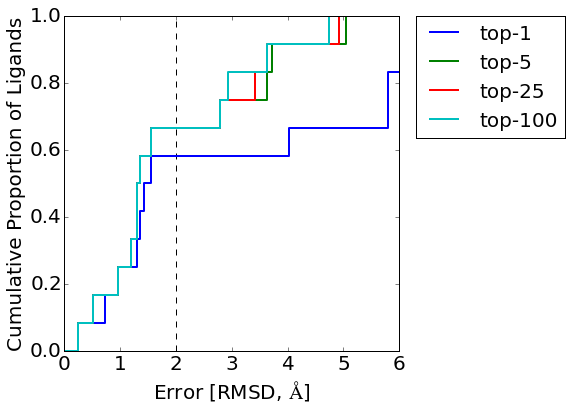

12
PLK1 4J52


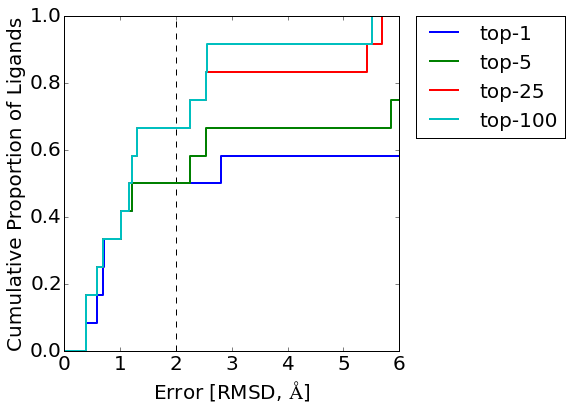

12
PLK1 4J53


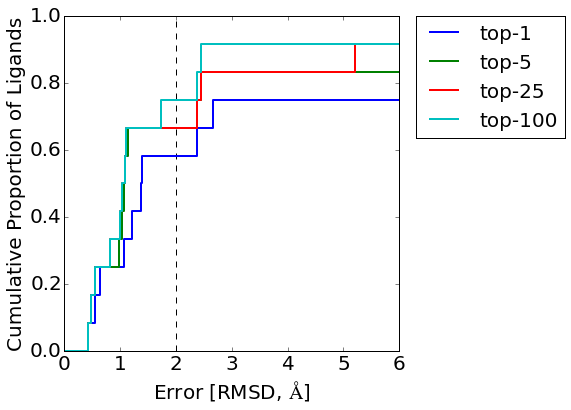

12
PLK1 5TA6


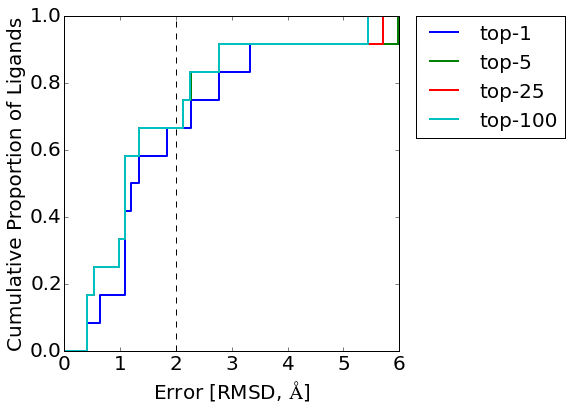

12
PLK1 5TA8


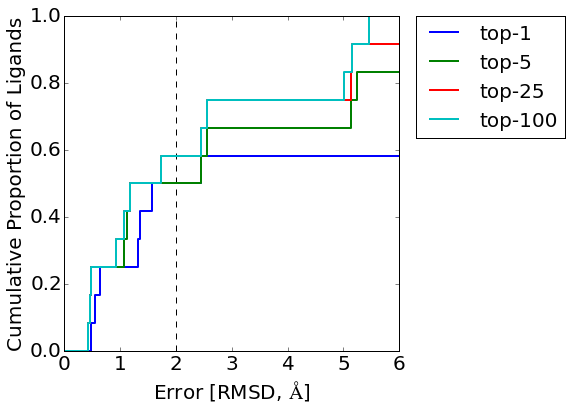

12


In [11]:
for p, prot in sorted(all_data.proteins.items()):
    ligands = ['{}_lig'.format(pdb) for pdb in prot.pdb_ids]
    best = 0
    for s, struct in sorted(prot.docking.items()):
        print p, s
        rmsds = all_data.glide_perf(s, [p], ligands=ligands)
        success = len([i for i in rmsds[-1] if i is not None and i<=2])/float(len(rmsds[-1]))
        print len(rmsds[-1])
        if success > best:
            best = success
            print s, success